# League of Legends Professional Game Data
## LSTM Neural Network to Predict Game Wins/Losses
## Michael Phillips

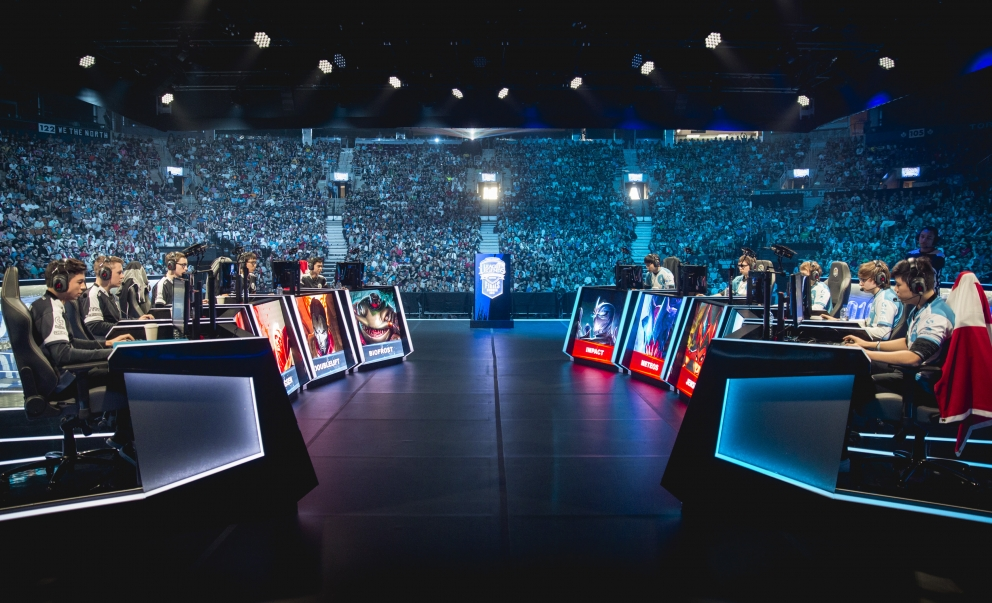

In [45]:
from IPython.display import Image

# 2017 League of Legends North American Finals
Image('0b702.jpg')

## Introduction

League of Legends is an online multiplayer computer game, with a rapidly evolving professional scene. In the past, similar games have come and gone. Due to its immense popularity and ongoing development LoL shows no signs of slowing down. I believe that in the near future the need for more in-depth data analysis will be necessary to compete at the highest level.

If you have never heard of League of Legends it might be helpful to imagine basketball. LOL and basketball are both 5 vs. 5 competitive matches. There are different tactics required depending on the players making up each team. The same rules (more or less) apply, no matter where or when you play. It is not that difficult to understand the goals and how to win, but mastery takes a very long time.

Another layer on top of the base game is that LOL has a professional league. The top prize for the best team is over 5 million dollars. The average player makes a six-figure income, with one player rumored to make 3 million dollars per year. Peak concurrent viewership for the league finals in 2016 was 14.7 million people, a number that compares favorably with recent MLB World Series TV ratings.

The goal for this project is to create a predictive model that will give win percentages per team for each minute in a game.

The potential client could be one of several invested parties.

- Riot Games, LOL's developer, could use the data and analysis found here to balance the game. Additionally, Riot handles all streaming production in-house. Providing a minute by minute win prediction would be an interesting stat to have available to announcers during a broadcast. 


- Professional coaches and owners are also a possible client. Data science has taken over scouting/player development in other professional sports, and in fact, LOL is no different. Data science already influences team composition and strategy. A predictive model for win percentages could help a team in a number of ways - from identifying underperforming players to finding the exact moment that a game turned from a potential win to a loss and how to avoid that circumstance in the future. 


To be slightly reductive, these organizations would be willing to invest in projects like the one shown here because of the substantial financial rewards that success would bring. Riot's primary goal is to grow LOL. The professional league is in and of itself an ad for the game as a whole. Its success brings eyes to the game and creates potential new customers who might download the game and eventually become paying customers.

For professional teams, the reward is again money. Besides the cash prizes awarded for winning, success will also bring higher quality and quantity of sponsors willing to invest in teams. This phenomenon is already apparent. Early on, sponsors were video game related companies such as gaming keyboard manufacturers. Today, sponsors include Coca-Cola. 

## The Data

Running the following cell will utilize a Python script that takes raw game data and returns properly formatted 3D arrays suitable for an LSTM network.

In [1]:
%run data_formatting.py

X_train shape:  (169440, 10, 22)
y_train shape:  (169440,)
X_test shape:  (42345, 10, 22)
y_test shape:  (42345,)


### Explanation of the data:
- The table below shows the final data formatting. 'match_id' denotes the game, and whether the team was on red or blue side of the game map. Each row is a snapshot of game statistics at that moment in time. There is one row per minute, per team, per game, counting upwards until the game ends. 


- The data was scaled in the previous script. The table visible here shows the unscaled data, which is a bit more intuitive to look at.


- Each sample (169,440 in the training set) is comprised of ten minute segments of game time. The first sample for the game below would consist of 'time' 0 through 9, the second sample would be 'time' 1 through 10, and so on until the game ends.


- There were a little over 3000 total games in the data set. Splitting the games into red and blue side and then segmenting into ten minute chunks resulted in the total samples used to train and test the neural network.


- Data wrangling steps undertaken for this model are detailed in the notebooks 'Feature Generation' and 'Feature_generation_pt_2' found within this repository.

In [2]:
df.head(10)

,match_id,time,gold,top_gold,jgl_gold,mid_gold,adc_gold,sup_gold,kill_total,assist_total,...,r_herald_count,r_drag_count,b_inhib_count,b_baron_count,b_tower_count,b_herald_count,b_dragon_count,kda,opp_kda,result
0,001a1f289e3bab22_b,0.0,2415.0,475.0,475.0,475.0,475.0,515.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,001a1f289e3bab22_b,1.0,2430.0,475.0,475.0,475.0,475.0,530.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,001a1f289e3bab22_b,2.0,2751.0,532.0,552.0,532.0,532.0,603.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,001a1f289e3bab22_b,3.0,3929.0,849.0,817.0,791.0,686.0,786.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,001a1f289e3bab22_b,4.0,5219.0,1099.0,1099.0,1107.0,976.0,938.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5,001a1f289e3bab22_b,5.0,6418.0,1466.0,1278.0,1352.0,1196.0,1126.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,1.5,0.0
6,001a1f289e3bab22_b,6.0,8156.0,1667.0,1708.0,1574.0,1687.0,1520.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,3.5,0.0
7,001a1f289e3bab22_b,7.0,9520.0,1970.0,2097.0,1708.0,1995.0,1750.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,3.5,0.0
8,001a1f289e3bab22_b,8.0,10681.0,2147.0,2414.0,1988.0,2244.0,1888.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,4.5,0.0
9,001a1f289e3bab22_b,9.0,12036.0,2605.0,2533.0,2321.0,2535.0,2042.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,4.5,0.0


## Model Training

See Appendix below for further information on how the model was created.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
%matplotlib inline

# create/compile model using previously optimized parameters
model = Sequential()
model.add(Dense(50,batch_input_shape=(4705, X_train[:-64].shape[1],X_train[:-64].shape[2]),
               kernel_constraint=maxnorm(1)))
model.add(Dropout(0.2))
model.add(LSTM(45, stateful=True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
         optimizer='rmsprop',
         metrics=['accuracy'])

In [18]:
# fit model on training data over 50 epochs
# store loss/accuracy scores in lists for plotting
loss = []
acc = []

for i in range(50):
    history = model.fit(X_train[:-64],y_train[:-64],batch_size=4705,
                        shuffle=False,epochs=1,verbose=0)
    loss.append(history.history['loss'])
    acc.append(history.history['acc'])
    model.reset_states()

### Model Loss


- Loss is a measure of how well the model fits the data. It is expected to decrease with each epoch, and ideally to find a good stopping point before overfitting the training set.


- The below graph reflects this process. The overall trend is still downwards toward the final epochs, however continuing to train the model results in worse performance likely due to overfitting. A middle ground was decided upon such that the model learns the overall trends but stops learning prior to memorizing the training set.

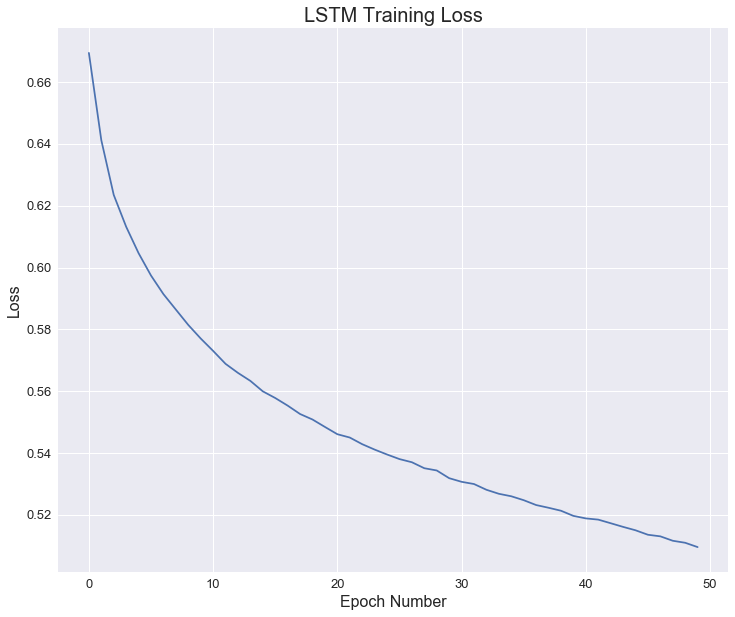

In [19]:
# create/format plot of model loss
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.plot(loss);
plt.title("LSTM Training Loss",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Epoch Number", fontsize=16)
plt.ylabel("Loss", fontsize=16);

### Model Accuracy


- Accuracy is a simple measure of how well the model functions. There are two classifications for this task (win or loss) so accuracy is determined by dividing the number of correct predictions by the total predictions.


- The below graph visualizes training accuracy. While the loss (model performance) goes down each epoch as neuron weights are updated, model accuracy goes up. The trend seen below shows the accuracy beginning to plateau, and a middle-ground was decided upon to ensure the model is as accurate as possible while still being able to generalize to data it has not seen in the test set.

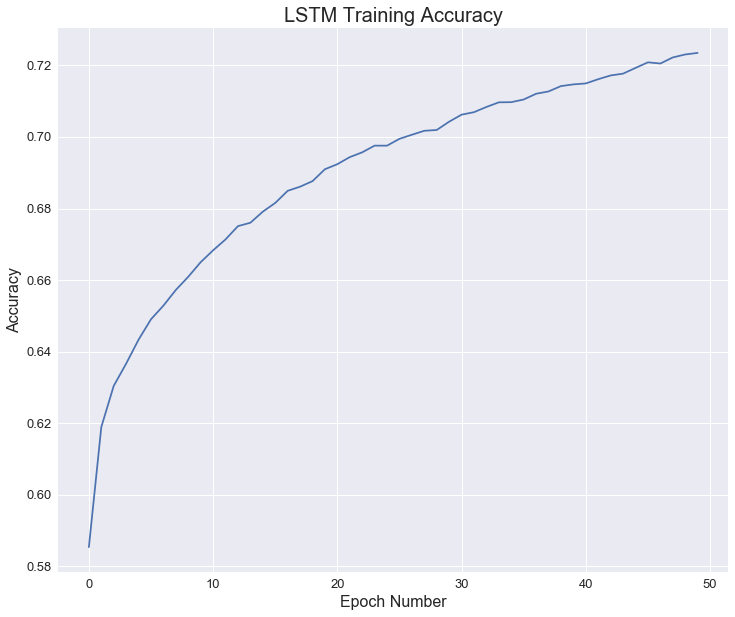

In [20]:
# create/format plot of model accuracy
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.plot(acc);
plt.title("LSTM Training Accuracy",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Epoch Number", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

## Model Results and Analysis

### Model Accuracy on the Test Set


- Final accuracy for the model on the test set was 64%. That is to say, for data the model has never seen it will accurately predict wins and losses 64% of the time. Baseline accuracy for this problem would be 50%, equivalent to flipping a coin to see which team would win a given game. 


### Analysis
64% accuracy is perhaps about as good as could be expected for this dataset. There were two main limitations of the data/model construction and one inherent aspect of League of Legends that led to this conclusion. 

#### Limitations of the data/model construction
- The dataset consisted of only ~3000 games. There are many thousands of League of Legends games played every day but that data is much harder to come by. Ideally, a model of this type could utilize most or all available game data.


- Computational power was limited. This project was completed using one desktop PC. While powerful in and of itself, it is no match for distributed computing available from services such as AWS. In a production environment distributed computing would lend itself to further refinement of parameter tuning, as well as allowing a much larger dataset to be used.

#### League of Legends Predictions

- As seen in professional sports where data science is a proven commodity, results vary by sport depending on inherent aspects of the game in question. As a gross oversimplification: basketball has more inherent randomness built into the game than baseball. For example, the bounce of the basketball off the rim towards one team or another in the final seconds of a game can decide a win/loss. Whereas with baseball, a win/loss is much more the result of what came before in the game and is readily quantified in statistics. The result: baseball is easier to create models for.


- LOL falls somewhere on this spectrum as well. There is skill that can be measured by statistics as was done here, but the randomness/luck that are inescapable also can influence a game. LOL is complex with many different moving parts that all come together to decide a winner. Not all of those aspects of the game are represented within the data. 


- Additionally, and familiar to many video game players, is the idea of a catch-up mechanic, or a specific rule in the game that allows a team to come from behind and secure victory. LOL indeed does have some aspects of this, perhaps as a concession to the millions of non-professional players. One example is that if you fall behind you will gain more experience. Game mechanics such as this make the data scientist's job more difficult but are necessary for the overall long-term health of the game.


- Data science relating to LOL has rapidly picked up recently with the influx of funding to professional teams. I expect descriptive statistics for LOL to evolve quickly, improving the performance of machine learning models on the game. For this project the goal was to utilize a neural network to solve a prediction problem, not necessarily to rewrite the book on LOL analysis.

In [21]:
# evaluate model using the test data
score = model.evaluate(X_test[:-31], y_test[:-31], verbose=0,batch_size=4705)
print("Model Loss: %.4f" % (score[0]))
print("Model Accuracy: %.2f%%" % (score[1]*100))

Model Loss: 0.6256
Model Accuracy: 63.46%


### Confusion Matrix 

- The confusion matrix below shows model accuracy. The split between accurate win predictions (1.0 below) and accurate loss predictions (0.0) was roughly equal across the data. A 'True' 0.0 and a predicted '0' means the model predicted correctly. A 'True' 0.0 and a predicted '1' means the model predicted incorrectly.

In [32]:
y_pred = model.predict_classes(X_test[:-31],batch_size=4705,verbose=0)

y_pred = y_pred.ravel()
y_test_reshape = y_test[:-31].ravel()

In [24]:
pd.crosstab(y_test_reshape, y_pred, rownames=['Actual'], 
            colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0.0,12595,8376,20971
1.0,7090,14284,21374
All,19685,22660,42345


## ROC Curve

In [34]:
y_pred = model.predict(X_test[:-31],batch_size=4705,verbose=0)

y_pred = y_pred.ravel()
y_test_reshape = y_test[:-31].ravel()

A ROC curve is used to see how well a classifier distinguishes between two groups, in this case wins or losses in professional LOL games. Ideally, the curve would be more spread out (ie. further from the baseline dotted black line). Consistent with the metrics and explanations shown above the particular classification done in this project is somewhat difficult to predict accurately due to chance, luck, and even to a certain extent, rules built into the game.

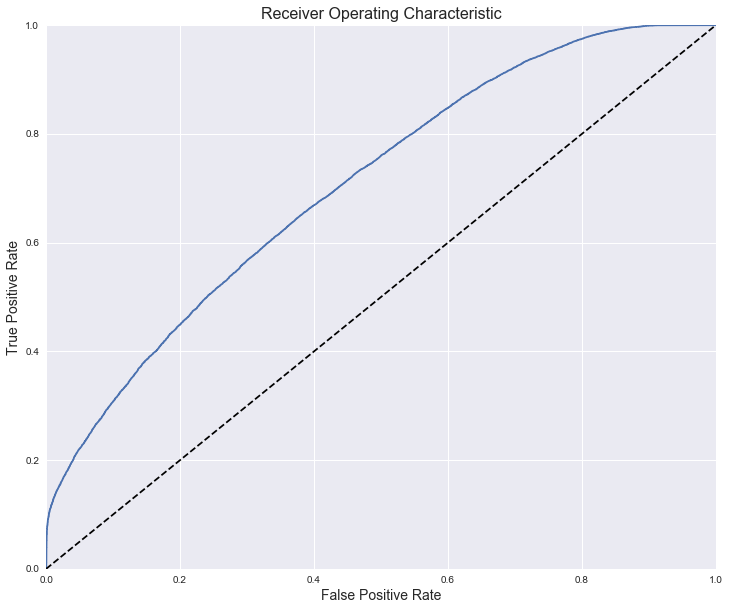

In [46]:
from sklearn.metrics import roc_curve

# compute metrics
fpr, tpr, thresholds = roc_curve(y_test_reshape, y_pred)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Receiver Operating Characteristic',fontsize=16);

# Minute by Minute Win Probability 
# 2016 League of Legends World Championship Finals

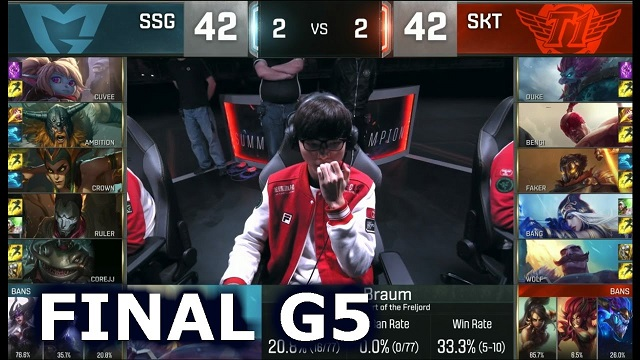

In [63]:
# A nail-biting moment before Game 5 of the 2016 Finals
Image('finals.jpg')

## SKT vs. SSG

The initial goal of this project was to do minute by minute predictions of which team would win the game. To demonstrate the model's use, let's look at the 2016 Finals between SSG and SKT. 

To League of Legends fans, the name SKT is legendary. They have appeared in the Finals every year of their existence, with a methodical, unrelenting style that is difficult to overcome. The team's heart and soul is their mid-laner, Faker. Faker is perhaps the most mechanically gifted player in the world, but his real value lies in doing whatever is necessary to enable his team to win. His solo plays that turn the tide of games are outside the realm of possibility for nearly any other player in the world. Most wouldn't even attempt what he makes look easy.

SKT's upstart opponent in the 2016 Finals was Samsung Galaxy. SSG, featuring a support player called CoreJJ who was new to the role, and a seasoned veteran called Ambition in the jungle, came together at just the right time to catapult themselves into the Finals. Most fans expected SKT to steamroll in the Finals in 3 games and take home another trophy. 

Let's see what happened.

In [116]:
# select and format game data for 2016 LOL Championship Games
%run game_formatting.py

In [117]:
# batch size reconfigured to 1 to predict minute by minute
batch_size_single_game = 1

# create new model with updated batch size
model2 = Sequential()
model2.add(Dense(50,batch_input_shape=(batch_size_single_game, X_train[:-64].shape[1],X_train[:-64].shape[2]),
               kernel_constraint=maxnorm(1)))
model2.add(Dropout(0.2))
model2.add(LSTM(45, stateful=True))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
         optimizer='rmsprop',
         metrics=['accuracy'])

# use weights from previous model to seed new model
calc_weights = model.get_weights()
model2.set_weights(calc_weights)

## Game 1 - Winner SKT

The gold differential plot below highlights some of the descriptive features of a LOL game. The dotted lines represent objectives, the red and blue markers are kills with multiple kills increasing marker size. The solid red line shows the gold differential between SKT and SSG. 0 means the two teams are equal, above 0 means SKT is winning and below 0 means SKT is losing. 

From this plot we can see that SKT took the majority of objectives, perhaps had slightly fewer kills but was overall able to take and hold a sizeable lead for most of the game. SSG valiantly attempted a comeback towards the end, but SKT's lead at that point was too big to overcome.

These metrics should provide predictive factors that the LSTM model can use to predict which team will win the game. Let's look at the minute by minute predictions.

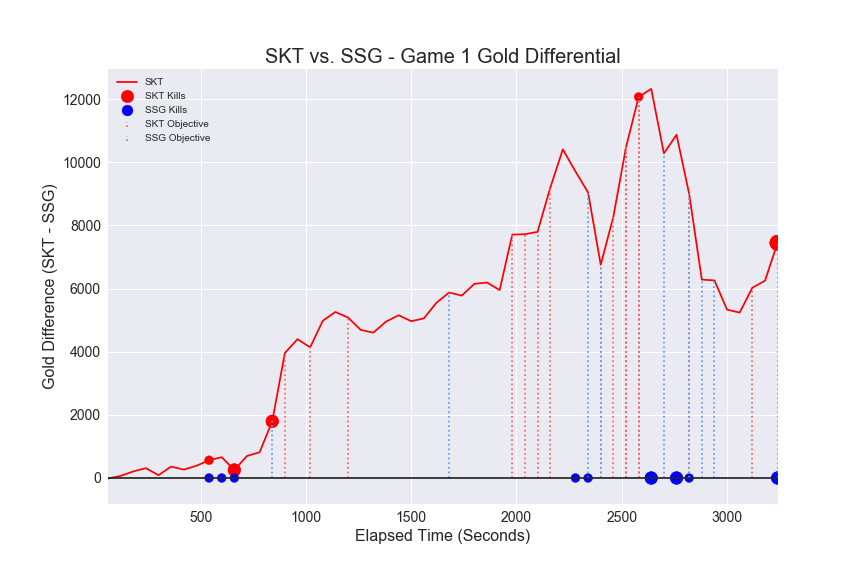

In [66]:
Image('game1.png')

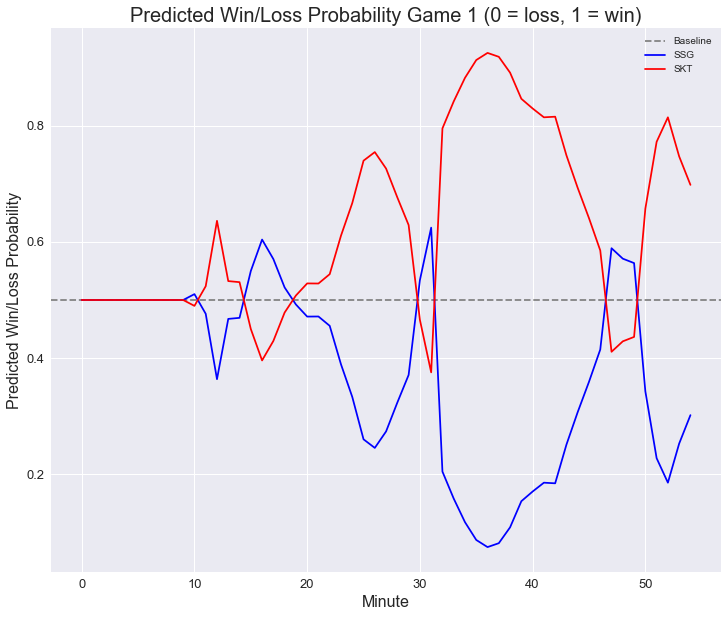

In [89]:
# predict red teams win probabilities
skt = model2.predict(xg1r,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
ssg = 1 - skt

# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = skt.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

# create/format plot for predicted probabilities
# Game 1 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability Game 1 (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## General Notes on Prediction Plots

- The graphs show predicted win percentages per team and per minute. The dotted gray line denotes the baseline expected win percentage of 50%. 


- The data was padded with the baseline win percentage for the first 10 minutes for two reasons. First, due to the structure of the model the first prediction is for minute 11. Second, in a professional setting it is close to impossible for a team to win in the first 10 minutes. In fact, the shortest recorded game in this dataset was around 18 minutes. This limitation is built into the game and made disregarding the first 10 minutes a reasonable choice for simplifying the model. 

## Game 1 Prediction Plot

This graph seems to mirror the gold differential plot above. Large stretches of the game were handily in SKT's favor (~95% predicted win probability around the 37 minute mark). Around the 47 minute mark SSG won several team fights (denoted by the large blue markers on the gold differential plot) and took objectives. During this period SSG actually had the edge in predicted win percentage. The final team fight was won by SKT however and they were able to close out the game in the end.

## Game 2 - Winner SKT

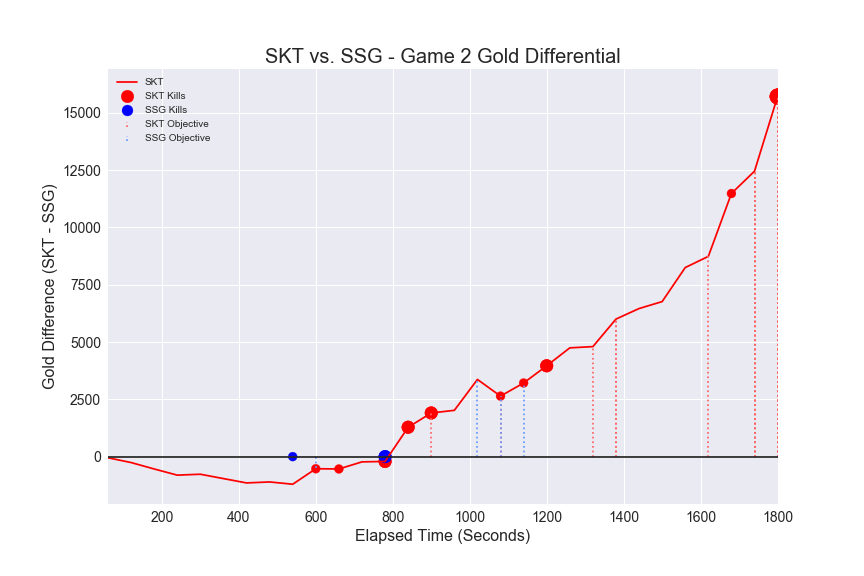

In [97]:
Image('game2.png')

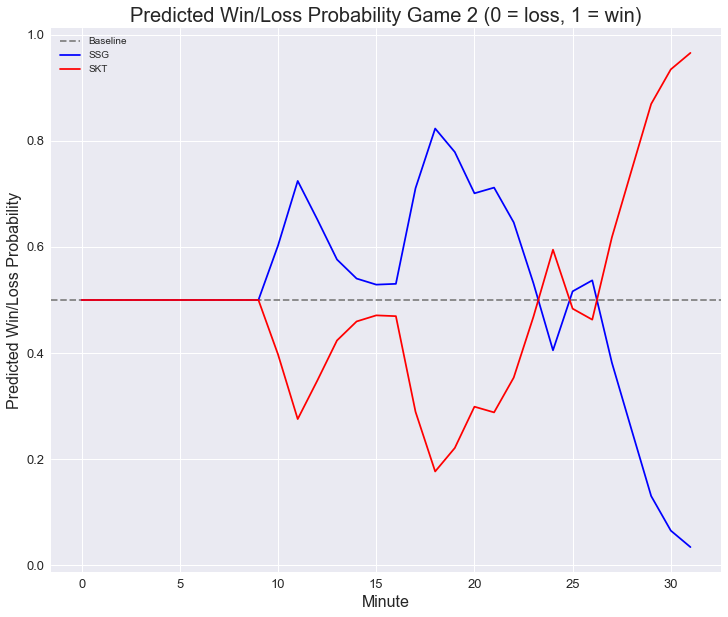

In [105]:
# predict red teams win probabilities
skt = model2.predict(xg2b,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
ssg = 1 - skt

# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = skt.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

# create/format plot for predicted probabilities
# Game 4 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability Game 2 (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## Game 2 Prediction Plot

Game 2 started with SSG taking an early lead. SKT had to fight to come back before ultimately taking the game. This plot highlights one of the drawbacks of the data, which is that it is impossible to tell specifics of what happened AFTER the team fights. The data only says players were killed, not WHICH players. A team has a greater chance to take objectives if the AD Carry lives through a fight. If only the support lives they will not be able to do much on their own.

A possible way to improve the model would be to add in which roles are alive at any given minute. 

## Game 3 - Winner SSG

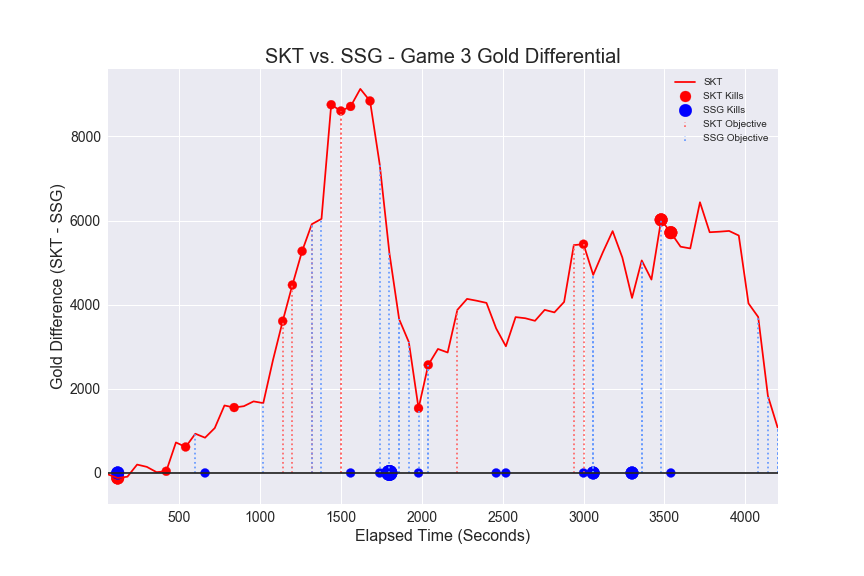

In [94]:
Image('game3.png')

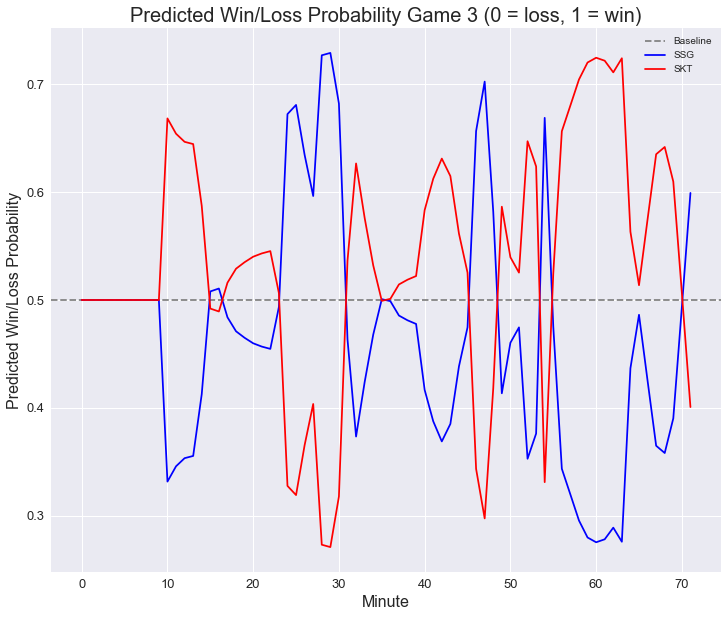

In [118]:
# predict red teams win probabilities
skt = model2.predict(xg3r,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
ssg = 1 - skt

# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = skt.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

# create/format plot for predicted probabilities
# Game 4 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability Game 3 (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## Game 3 Prediction Plot
This plot pretty much tells the tale of this game. With SSG on the verge of losing the Finals they appeared determined to win at least one game. For their own part SKT wanted to close out the series as quickly as possible and take home their second Championship in a row. 

It was a wild back-and-forth match lasting over 70 minutes (extremely long for a LOL game). The gold differential plot shows both teams securing many kills and objectives and the predictive model echoes this, swinging between predicting SKT and SSG as the winner. Ultimately, SSG was able to secure the important objectives towards the end and to take the win prolonging the series for at least one more game.

## Game 4 - Winner SSG


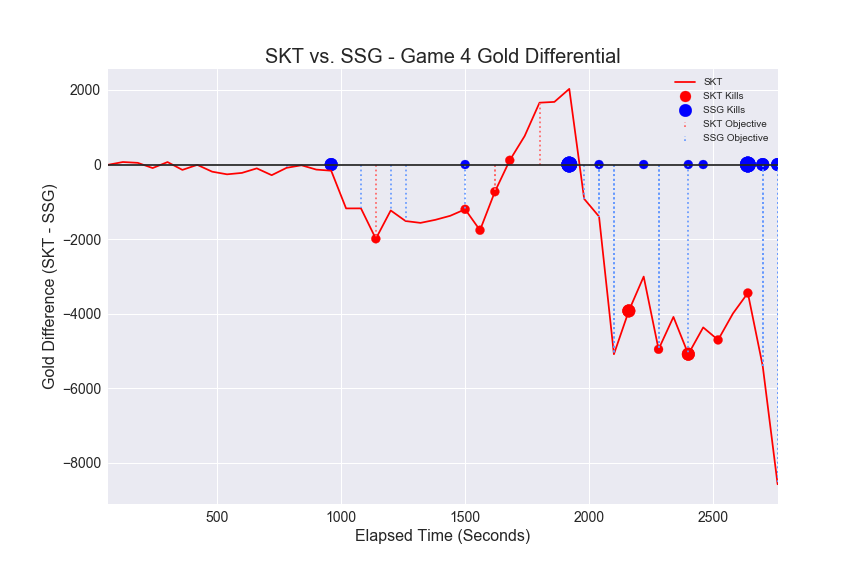

In [95]:
Image('game4.png')

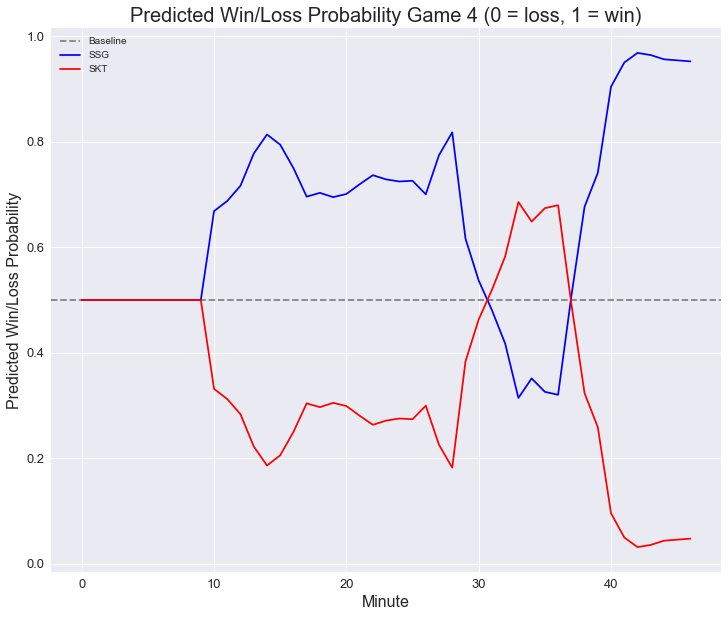

In [106]:
# predict red teams win probabilities
skt = model2.predict(xg4b,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
ssg = 1 - skt

# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = skt.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

# create/format plot for predicted probabilities
# Game 4 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability Game 4 (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## Game 4 Prediction Plot

This was a much cleaner win for SSG. Except for a brief interlude towards the end of the game the model handily predicted an SSG victory. The gold differential plot shows SKT was able to secure kills but the vast majority of objectives went to SSG. Kills are an interesting metric and perhaps illustrate another obstacle in terms of making predictions - in some games kills are a trustworthy predictive measure, the team with the most kills wins the game. In other games, a team will give up kills in favor of taking objectives and rotating around the map to gather resources. Either strategy can be successful but a predictive model will have difficulty making this distinction.

In any case, SSG came out the winner in game 4 and forced a decisive game 5.

## Game 5 - Winner SKT

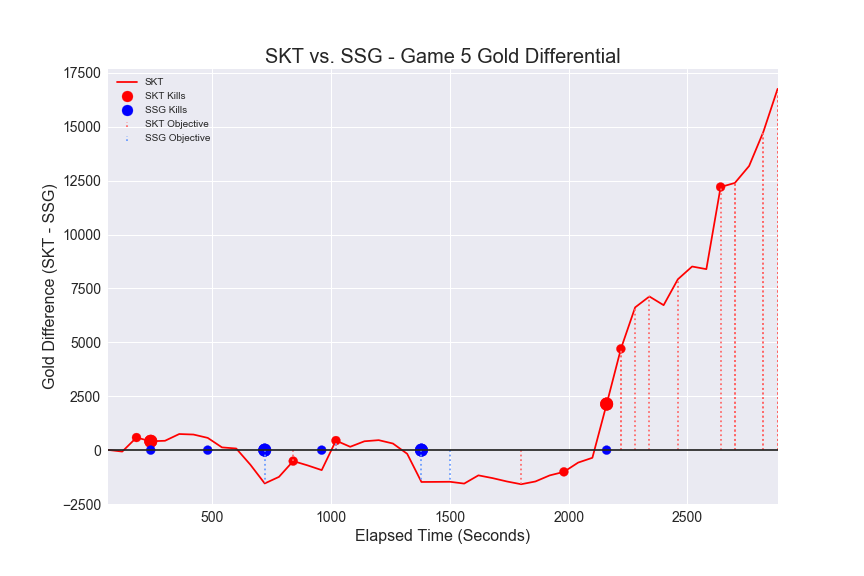

In [96]:
Image('game5.png')

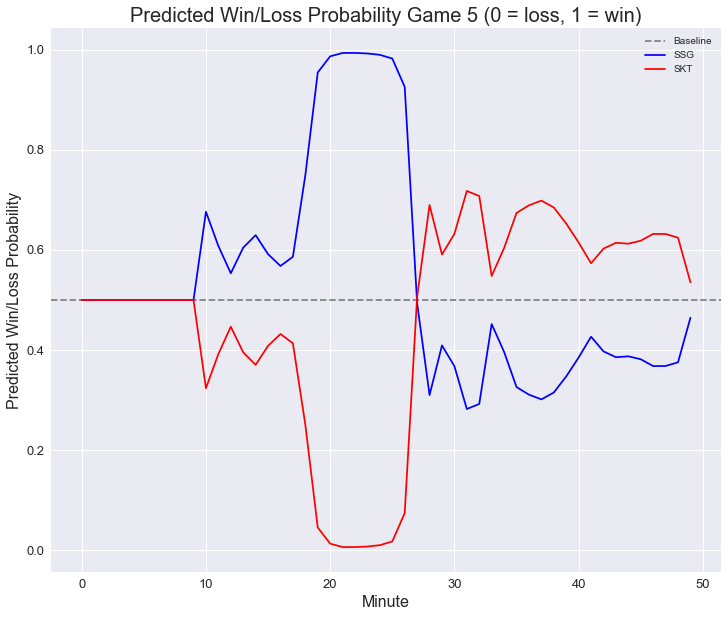

In [129]:
# predict red teams win probabilities
skt = model2.predict(xg5b,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
ssg = 1 - skt

# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = skt.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

# create/format plot for predicted probabilities
# Game 4 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability Game 5 (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## Game 5 Prediction Plot
This game was another up-and-down slugfest worthy of being the final game of the season and the last game of the Championship. The game was really up in the air until quite late with both teams on relatively equal footing. This particular prediction plot is the least descriptive when compared to the gold differential plot seen so far. One possible reason for this would be that the game was very close and the model does not accurately know how to handle close games 100% of the time. 

The game ended up coming down to several team fights at the end which SKT pulled out. After securing subsequent objectives SKT was able to finish the game and win the Championship, defeating SSG in 5 games.

One additional note for the curious (or those rooting for the underdog) - the 2017 Finals featured a rematch between SKT and SSG, which SSG won 3 games to 0 becoming the first team to ever defeat SKT in an international tournament.

## Conclusion

League of Legends has turned into a fascinating game and industry. Its immense popularity has steadily grown since the initial release in October 2009 into the gaming juggernaut LOL is today. In the past week (as of this writing) new teams owned and operated by NBA/MLB owners have joined the professional league, including the owners of the Golden State Warriors and Cleveland Cavs. These owners bring a level of funding and proven processes previously unseen in e-sports. Additionally, Disney-owned BAMTech has inked a $300 million deal to exclusively stream LOL to the world. At this point it is hard to say exactly how popular LOL could possibly be, but powerful, successful businesses have high hopes.

The model created here, as well as the EDA, were not created in a vacuum. There is significant money up for grabs in League of Legends. The winners will likely be those that make the most effective use of the data. 

For teams, this model could be used to mold their players to play a certain style of LOL, a style pulled from the data to maximize effectiveness and the team's chance to win. Or the model could be used to find trends amongst winning teams, such as before 15 minutes, winning teams have generally destroyed 2 towers and taken at least 1 dragon. Alternatively, the model could also identify trends of losing teams, such as by 10 minutes losing teams have on average 3 team deaths. That knowledge could lead to a strategy to play defensively for the opening minutes to avoid a deficit heading into the midgame.

For Riot itself, and its partners such as BAMTech, the model could be used to identify games with a high likelihood of being competitive and they could then focus their marketing on those games. If people tune in to watch 1 game and it happens to be a really good game, they would be more likely to return, or to even try LOL for themselves. Another possibility for Riot is to use the model to identify problematic trends within the game. For example, the model could be used to tune game length. Game length is something that other professional sports consider every few years. An NFL game lasting 4 hours is not conducive to how most people live their lives. Perhaps Riot thinks reducing game length by 5 minutes would increase viewership - they could use the model to discover ideal winning conditions and then tune the game underlying structure to arrive at those numbers slightly earlier in game time.

While e-sports was the chosen topic for this project, the underlying idea was to find a business use case for machine learning. By themselves, predictive models are simply representations of data. It is up to the people that create them to find the stakeholder value they hold within.

## Appendix

### Explanation of Model Tuning

- The data was formatted into a simple time series with the eventual goal of being able to predict game wins and losses at each minute. It was essential that the model be able to make connections between stats early in the game and later on. For these reasons a recurrent neural network was chosen, specifically an LSTM for its proven performance on time series problems.


- The final model constructed in the following cell was the result of extensive tuning. The final configuration that provided the best performance turned out to be: DENSE->DROPOUT->LSTM->OUTPUT. Other potential structures tested were LSTM->OUTPUT, and LSTM->DENSE->OUTPUT both with and without DROPOUT layers.


- Dropout was found to be a neccesary component of the model to alleviate overfitting as much as possible.


- Other parameters tuned include: neurons in each layer, dropout rates, weight constraint, batch size, and epoch.


- Model creation/tuning steps can be found in the notebooks 'data_formatting_for_neural_network' and 'data_formatting_for_NN_pt2' also available in this repository.